In [1]:
# ------- Date structure
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ------- Data preperation
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Features Overview

The dataset contains 19 features and 418 observations. There are numeric and categorical features and missing values are shown in numerous variables.

In [3]:
# Read Data From csv file
df = pd.read_csv('cirrhosis.csv')

## first view on the dataset - Features: 19, Observations: 418
print("Features: "+ str(df.shape[1]-1)+ ", Observations: " + str(df.shape[0]))
df.info()

Features: 19, Observations: 418
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non

# Removal of sample identifier - ID
Removed the ID column, as it was not analytically relevant.


In [4]:
# Removal of ID feature
df = df.drop(columns=['ID'])

# Duplicate records
We have defined a duplicate record as a record whose fields are identical to another. Accordingly, no duplicates were found.


In [5]:
# Duplicates - there are none
df.duplicated().sum()

0

# Missing Values


In [6]:
# Create a summary of missing values
missing_summary = pd.DataFrame({
    'Feature': df.columns,
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='Missing Count', ascending=False)

# Display the summary
print(missing_summary)


# Remove rows where Missing Count is 0
missing_summary_no_zeros = missing_summary[missing_summary['Missing Count'] > 0]

# Centralize and format the table
styled_summary_no_zeros = missing_summary_no_zeros.style.set_properties(**{
    'text-align': 'center'
}).set_table_styles([
    dict(selector='th', props=[('text-align', 'center')])
])

# Display the updated table
print(f"\n Nicer summary with no zeros \n {missing_summary_no_zeros}")


                     Feature  Missing Count  Missing Percentage
Tryglicerides  Tryglicerides            136           32.535885
Cholesterol      Cholesterol            134           32.057416
Copper                Copper            108           25.837321
Drug                    Drug            106           25.358852
Ascites              Ascites            106           25.358852
Hepatomegaly    Hepatomegaly            106           25.358852
Spiders              Spiders            106           25.358852
SGOT                    SGOT            106           25.358852
Alk_Phos            Alk_Phos            106           25.358852
Platelets          Platelets             11            2.631579
Stage                  Stage              6            1.435407
Prothrombin      Prothrombin              2            0.478469
N_Days                N_Days              0            0.000000
Albumin              Albumin              0            0.000000
Status                Status            

Missing values were noted in several features. We grouped these features based on the proportion of missing data:


1.   **Significant Missing Data** (≥25%): Features like Tryglicerides, Cholesterol, Copper, Drug, Ascites, Hepatomegaly, Spiders, SGOT, and Alk_Phos had over 25% of their values missing.


*   According to the dataset source, the **Drug** feature was missing for 106 patients because they did not participate in the clinical trial. As non-participants, we imputed their Drug values as Non-participant to reflect this distinction.
*   For the **remaining features** in this category, missing values were imputed using the median value of the target group (since the median is robust to outliers and better represents central tendency for skewed data).

2.   **Minimal Missing Data** (<3%): Platelets, Stage, and Prothrombin.


*   **Stage** -  This feature is the target variable. There were 6 samples with missing values. We removed these samples from the data set because the number of such observations was small, and we did not want to introduce noise when completing their value.
*   **Platelets and Prothrombin** - We handled these continuous features with the median value.






## Step 1: Impute the Drug feature
According to the dataset source, missing Drug values reflect patients who did not participate in the clinical trial. Hence, we fill null values with a new category to represent these patients.


In [7]:
df['Drug'].fillna('Non-participant', inplace=True)

<ipython-input-7-170befda32de>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Drug'].fillna('Non-participant', inplace=True)


## Step 2: Remove rows where the target feature (Stage) is missing

Where the target value is missing, the clinic stopped monitoring the patient.

In [8]:
df_cleaned = df.dropna(subset=['Stage'])

## Step 3: Impute categorical variables with the mode of their Stage class

In [9]:
categorical_features = ['Ascites', 'Hepatomegaly', 'Spiders']
for feature in categorical_features:
    if feature in df_cleaned.columns:
        df_cleaned[feature].fillna(df_cleaned.groupby('Stage')[feature].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None), inplace=True)

<ipython-input-9-b0922e2ac361>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[feature].fillna(df_cleaned.groupby('Stage')[feature].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None), inplace=True)
<ipython-input-9-b0922e2ac361>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[feature].fillna(df_cleane

In [11]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Step 4: Impute numeric variables with the median of their Stage class

In [12]:
numeric_features = ['Tryglicerides', 'Cholesterol', 'Copper', 'SGOT', 'Alk_Phos', 'Platelets', 'Prothrombin']
for feature in numeric_features:
    if feature in df_cleaned.columns:
        df_cleaned[feature].fillna(df_cleaned.groupby('Stage')[feature].transform('median'), inplace=True)


<ipython-input-12-caa032cad9f2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[feature].fillna(df_cleaned.groupby('Stage')[feature].transform('median'), inplace=True)
<ipython-input-12-caa032cad9f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[feature].fillna(df_cleaned.groupby('Stage')[feature].transform('median'),

## Final check for any remaining missing values

In [ ]:
#print(df_cleaned.isnull().sum().sum())
df_cleaned.isnull().sum()

,0
N_Days,0
Status,0
Drug,0
Age,0
Sex,0
Ascites,0
Hepatomegaly,0
Spiders,0
Edema,0
Bilirubin,0


In [ ]:
# Current number of observations - 412
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         412 non-null    int64  
 1   Status         412 non-null    object 
 2   Drug           412 non-null    object 
 3   Age            412 non-null    int64  
 4   Sex            412 non-null    object 
 5   Ascites        412 non-null    object 
 6   Hepatomegaly   412 non-null    object 
 7   Spiders        412 non-null    object 
 8   Edema          412 non-null    object 
 9   Bilirubin      412 non-null    float64
 10  Cholesterol    412 non-null    float64
 11  Albumin        412 non-null    float64
 12  Copper         412 non-null    float64
 13  Alk_Phos       412 non-null    float64
 14  SGOT           412 non-null    float64
 15  Tryglicerides  412 non-null    float64
 16  Platelets      412 non-null    float64
 17  Prothrombin    412 non-null    float64
 18  Stage          

# Data Proportion - Imbalance Data

In [13]:
# Yarden fill in here the code you used for merging categories
df_cleaned['Stage_combined'] = df_cleaned['Stage'].replace({1: 1, 2: 1, 3: 2, 4: 3})

# Compare the original 'Stage' column with the new 'Stage_combined' column
df_cleaned[['Stage', 'Stage_combined']].drop_duplicates()



<ipython-input-13-377f610ac1de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Stage_combined'] = df_cleaned['Stage'].replace({1: 1, 2: 1, 3: 2, 4: 3})


,Stage,Stage_combined
0,4.0,3.0
1,3.0,2.0
8,2.0,1.0
51,1.0,1.0


In [14]:
df_cleaned['Stage'] = df_cleaned['Stage_combined']

df_cleaned = df_cleaned.drop('Stage_combined', axis = 1)

df_cleaned['Stage'].drop_duplicates()

<ipython-input-14-12af03f9d4cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Stage'] = df_cleaned['Stage_combined']


,Stage
0,3.0
1,2.0
8,1.0


# Data Representation

## Lable Encoding and One-Hot Encoding

This stage ensures that any model treats categories as distinct and avoids implying ordinal relationships for categorical features.

### Dummy variables
Categorial variables with more than two possible values will be encoded with extra featres.

In [15]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['Status', 'Drug', 'Edema']

print(f"Before:\n{df_cleaned[categorical_features]}")

df = pd.get_dummies(df_cleaned, columns=categorical_features, drop_first=True)
new_columns = [col for col in df.columns if any(feature in col for feature in categorical_features)]

print(f"New added features:\n{new_columns}")

Before:
    Status             Drug Edema
0        D  D-penicillamine     Y
1        C  D-penicillamine     N
2        D  D-penicillamine     S
3        D  D-penicillamine     S
4       CL          Placebo     N
..     ...              ...   ...
413      D  Non-participant     N
414      C  Non-participant     N
415      C  Non-participant     N
416      C  Non-participant     N
417      C  Non-participant     N

[412 rows x 3 columns]
New added features:
['Status_CL', 'Status_D', 'Drug_Non-participant', 'Drug_Placebo', 'Edema_S', 'Edema_Y']


### Binary variables
Variables with only two possible values will be encoded with 0 or 1 values.

In [16]:
binary_categorical_features = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders']
binary_categorical_features = binary_categorical_features + new_columns
print(f" Before: \n {df[binary_categorical_features]}")

# Label encode categorical features
label_encoders = {}
for feature in binary_categorical_features:
    if feature in df.columns:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
        label_encoders[feature] = le  # Store the encoder for future use

# Create a mapping for label encoding to identify the categories
label_mappings = {}
for feature in binary_categorical_features:
    if feature in label_encoders:
        original_values = list(label_encoders[feature].classes_)  # Get original values
        encoded_values = [0, 1]  # Encoded values
        label_mappings[feature] = {original: encoded for original, encoded in zip(original_values, encoded_values)}

print(f" After: \n {df[binary_categorical_features]}")

# Create a table from label_mappings
label_mapping_table = []
for feature, mapping in label_mappings.items():
    for original, encoded in mapping.items():
        label_mapping_table.append({'Feature': feature, 'Original Value': original, 'Encoded Value': encoded})

# Convert to DataFrame
label_mapping_df = pd.DataFrame(label_mapping_table)

 Before: 
     Sex Ascites Hepatomegaly Spiders  Status_CL  Status_D  \
0     F       Y            Y       Y      False      True   
1     F       N            Y       Y      False     False   
2     M       N            N       N      False      True   
3     F       N            Y       Y      False      True   
4     F       N            Y       Y       True     False   
..   ..     ...          ...     ...        ...       ...   
413   F       N            N       N      False      True   
414   F       N            Y       N      False     False   
415   F       N            N       N      False     False   
416   F       N            N       N      False     False   
417   F       N            Y       N      False     False   

     Drug_Non-participant  Drug_Placebo  Edema_S  Edema_Y  
0                   False         False    False     True  
1                   False         False    False    False  
2                   False         False     True    False  
3               

### Table of encoded variables

In [17]:
# Avital add code that takes the lables encoding and turns it to a table
label_mapping_df_transposed = label_mapping_df.set_index('Feature').T
label_mapping_df_transposed



Feature,Sex,Sex,Ascites,Ascites,Hepatomegaly,Hepatomegaly,Spiders,Spiders,Status_CL,Status_CL,Status_D,Status_D,Drug_Non-participant,Drug_Non-participant,Drug_Placebo,Drug_Placebo,Edema_S,Edema_S,Edema_Y,Edema_Y
Original Value,F,M,N,Y,N,Y,N,Y,False,True,False,True,False,True,False,True,False,True,False,True
Encoded Value,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


In [18]:
new_label_mapping_df = label_mapping_df[label_mapping_df['Feature'].isin(new_columns)]
print(new_label_mapping_df.set_index('Feature').T)

old_label_mapping_df = label_mapping_df[~label_mapping_df['Feature'].isin(new_columns)]
print (old_label_mapping_df.set_index('Feature').T)


Feature        Status_CL Status_CL Status_D Status_D Drug_Non-participant  \
Original Value     False      True    False     True                False   
Encoded Value          0         1        0        1                    0   

Feature        Drug_Non-participant Drug_Placebo Drug_Placebo Edema_S Edema_S  \
Original Value                 True        False         True   False    True   
Encoded Value                     1            0            1       0       1   

Feature        Edema_Y Edema_Y  
Original Value   False    True  
Encoded Value        0       1  
Feature        Sex Sex Ascites Ascites Hepatomegaly Hepatomegaly Spiders  \
Original Value   F   M       N       Y            N            Y       N   
Encoded Value    0   1       0       1            0            1       0   

Feature        Spiders  
Original Value       Y  
Encoded Value        1  


## Handeling Outliers

In [19]:
# Function to apply log transformation to numerical columns
def log_transform(dataframe, columns):
    transformed_data = dataframe.copy()
    for col in columns:
        if col in transformed_data.columns:
            transformed_data[col] = np.log(transformed_data[col] + 1)  # Add 1 to avoid log(0)
    return transformed_data

# Apply log transformation
data_log_transformed = log_transform(df, numeric_features)

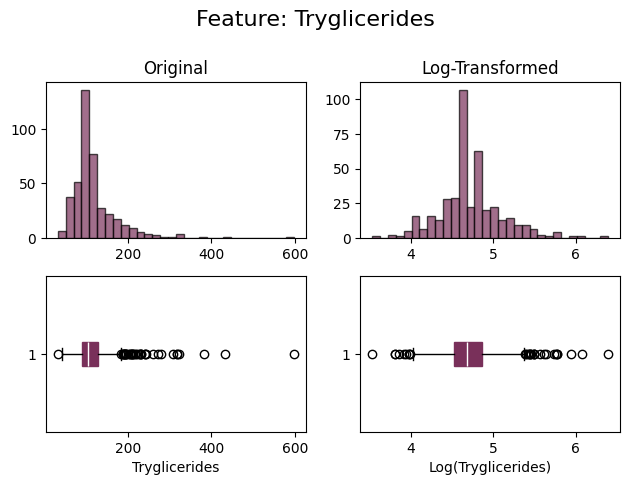

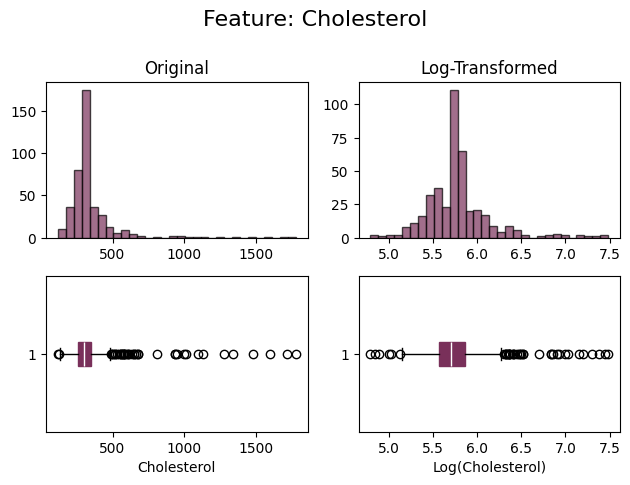

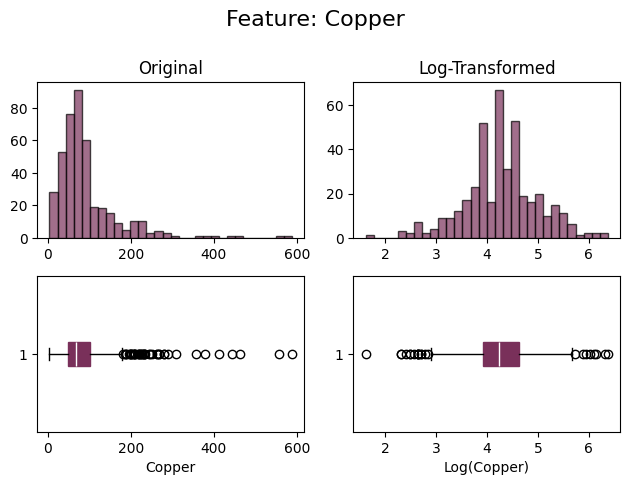

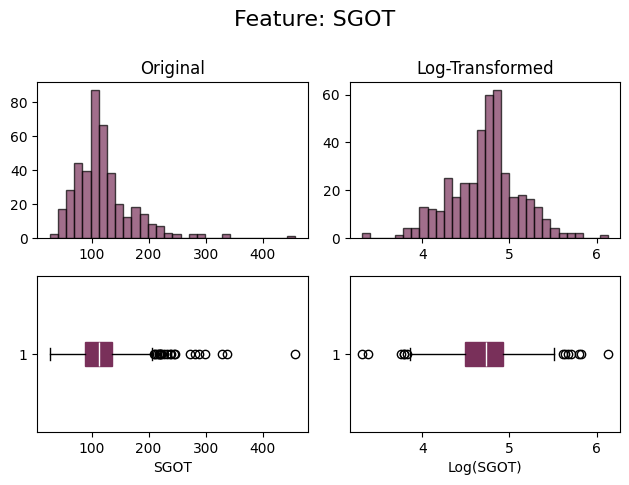

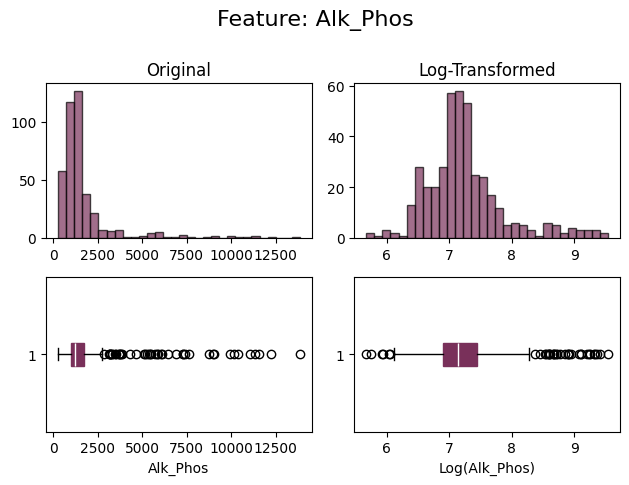

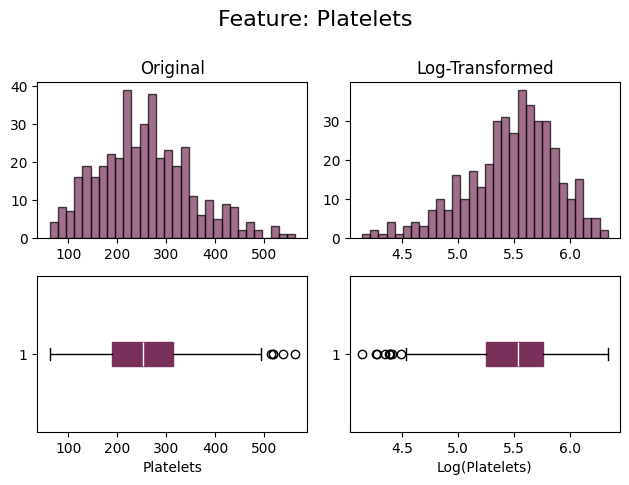

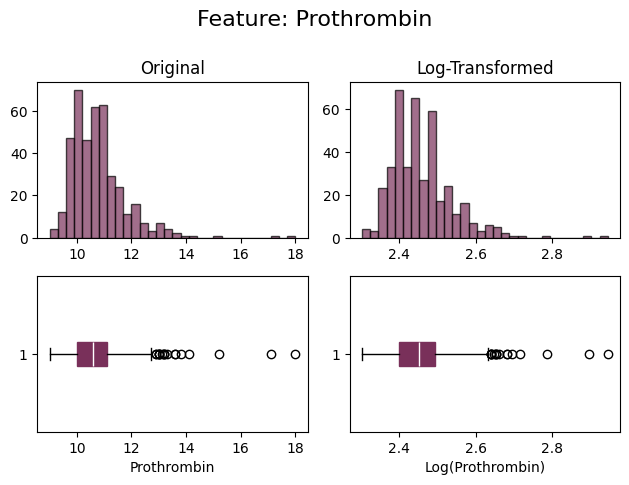

In [20]:
columns_to_visualize = numeric_features

color_hex = "#79305a"  # The purple color you used in the histogram

for col in columns_to_visualize:
    plt.figure()
    plt.suptitle(f"Feature: {col}", fontsize=16, ha='center', va='center')
    # Original distribution
    plt.subplot(2, 2, 1)
    plt.hist(df[col].dropna(), bins=30, edgecolor='k', alpha=0.7, color=color_hex)
    plt.title(f"Original")
    #plt.xlabel(col)
    #plt.ylabel('Frequency')

    # Transformed distribution
    plt.subplot(2, 2, 2)
    plt.hist(data_log_transformed[col].dropna(), bins=30, edgecolor='k', alpha=0.7, color=color_hex)
    plt.title(f"Log-Transformed")
    #plt.xlabel(f"Log({col})")
    #plt.ylabel('Frequency')



    # Original distribution boxplot
    plt.subplot(2, 2, 3)
    plt.boxplot(df[col].dropna(), vert=False,
                patch_artist=True,  # This allows filling the box with color
                boxprops=dict(facecolor=color_hex, color=color_hex),  # Box fill and edge color
                medianprops=dict(color='white'))  # Median line color
    #plt.title(f"Original Distribution of {col}")
    plt.xlabel(col)

    # Transformed distribution boxplot
    plt.subplot(2, 2, 4)
    plt.boxplot(data_log_transformed[col].dropna(), vert=False,
                patch_artist=True,
                boxprops=dict(facecolor=color_hex, color=color_hex),
                medianprops=dict(color='white'))
    #plt.title(f"Log-Transformed Distribution of {col}")
    plt.xlabel(f"Log({col})")

    plt.tight_layout()
    plt.show()

## Dataset Scailing
**Yarden**

# Feature Selection

## Detecting Multicollinearity with VIF

In [21]:
## Define features and target
X = df.drop('Stage', axis='columns')
Y = df['Stage']

## VIF score
# VIF dataframe
def vif_calc(vif_data, X):
    vif_data["Feature"] = X.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                       for i in range(len(X.columns))]
    return vif_data.sort_values(by="VIF", ascending=False)

def vif_print(X):
    vif_data = vif_calc(pd.DataFrame(), X)

    def color_vif(val):
        """Color cells red if VIF > 10, otherwise black."""
        if isinstance(val, (int, float)):  # Ensure we handle only numeric values
            return 'color: red' if val > 10 else 'color: black'
        return ''  # No styling for non-numeric cells

    styled_vif = vif_data.style.format({"VIF": "{:.2f}"}).hide(axis='index').set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center')]},
         {'selector': 'td', 'props': [('text-align', 'center')]}]
    ).set_properties(**{'border': '1px solid black', 'padding': '5px'}).map(
        lambda x: color_vif(x)
    )

    display(styled_vif)  # Explicitly display the styled table

# Call the function to display the VIF table
vif_print(X)

Feature,VIF
Prothrombin,80.75
Albumin,64.12
Age,26.89
Platelets,9.96
SGOT,9.01
Tryglicerides,7.70
N_Days,7.13
Cholesterol,5.90
Copper,3.89
Bilirubin,2.99


In [22]:
# Dropping 'Prothrombin'
df = df.drop(columns=['Prothrombin'], axis=1)
X = df.drop('Stage' , axis='columns')
Y = df['Stage']
vif_print(X)

Feature,VIF
Albumin,39.89
Age,22.53
Platelets,9.89
SGOT,8.74
Tryglicerides,7.69
N_Days,7.02
Cholesterol,5.90
Copper,3.89
Bilirubin,2.93
Status_D,2.74


In [23]:
# Dropping 'Albumin'
df = df.drop(columns=['Albumin'], axis=1)
X = df.drop('Stage' , axis='columns')
Y = df['Stage']
vif_print(X)

Feature,VIF
Age,14.99
Platelets,8.77
SGOT,8.10
Tryglicerides,7.46
Cholesterol,5.86
N_Days,5.60
Copper,3.88
Bilirubin,2.88
Status_D,2.74
Hepatomegaly,2.51


In [24]:
# Dropping 'Age'
df = df.drop(columns=['Age'], axis=1)
X = df.drop('Stage' , axis='columns')
Y = df['Stage']
vif_print(X)

Feature,VIF
SGOT,7.70
Platelets,7.48
Tryglicerides,7.09
Cholesterol,5.85
N_Days,4.91
Copper,3.85
Bilirubin,2.78
Status_D,2.61
Hepatomegaly,2.39
Alk_Phos,2.34


In [25]:
df.to_csv('cirrhosis_preprocessed.csv', index=False)

In [26]:
df

,N_Days,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Stage,Status_CL,Status_D,Drug_Non-participant,Drug_Placebo,Edema_S,Edema_Y
0,400,0,1,1,1,14.5,261.0,156.0,1718.0,137.950,172.0,190.0,3.0,0,1,0,0,0,1
1,4500,0,0,1,1,1.1,302.0,54.0,7394.8,113.520,88.0,221.0,2.0,0,0,0,0,0,0
2,1012,1,0,0,0,1.4,176.0,210.0,516.0,96.100,55.0,151.0,3.0,0,1,0,0,1,0
3,1925,0,0,1,1,1.8,244.0,64.0,6121.8,60.630,92.0,183.0,3.0,0,1,0,0,1,0
4,1504,0,0,1,1,3.4,279.0,143.0,671.0,113.150,72.0,136.0,2.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,681,0,0,0,0,1.2,324.0,67.5,1257.5,112.375,119.0,174.0,2.0,0,1,1,0,0,0
414,1103,0,0,1,0,0.9,299.0,98.5,1428.0,122.450,106.0,180.0,3.0,0,0,1,0,0,0
415,1055,0,0,0,0,1.6,324.0,67.5,1257.5,112.375,119.0,143.0,2.0,0,0,1,0,0,0
416,691,0,0,0,0,0.8,324.0,67.5,1257.5,112.375,119.0,269.0,2.0,0,0,1,0,0,0
